# 🌟 TripAdvisor Hotel Reviews: A Deep Dive 🌟

#### Sentiment Analysis - Analyzing reviews is like reading a book where each review is a page, and together they tell a story. Let's uncover the story these hotel reviews are trying to tell!

## Table of Contents:

1. [Introduction & Data Peek](#introduction-and-data-peek)
2. [Data Cleaning & Preprocessing](#data-cleaning-and-preprocessing)
3. [Exploratory Data Analysis (EDA)](#exploratory-data-analysis)
4. [Predicting Review Ratings](#predicting-review-ratings)
5. [Sentiment Analysis](#sentiment-analysis)
6. [Predictions Using the Sentiment Model](#predictions-using-the-sentiment-model)
7. [Conclusion](#conclusion)

### 1. Introduction & Data Peek <a name="introduction-and-data-peek"></a>

Hello there! If you've stumbled upon this Jupyter Notebook, then either you are lost in the vast world of data science or you have an insatiable thirst for knowledge. Either way, you're in for a treat. Today, we'll be analyzing TripAdvisor hotel reviews because who doesn't like to know what makes a hotel stay feel like heaven or, occasionally, the other place...

Before we jump into the deep end, let's take a quick peek at our data to get a sense of what we're working with.

`Source of the dataset: https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews/code?datasetId=897156&sortBy=voteCount `

In [1]:
# Importing the relevant packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Basic text preprocessing
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

Let's peek at the data, shall we? Before we jump into the deep end, let's take a quick peek at our data to get a sense of what we're working with.

In [2]:
# Load the dataset
df = pd.read_csv(r"data/tripadvisor_hotel_reviews.csv")
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


Ah, simplicity! Each row represents a review with its respective rating. The 'Review' column contains the text of the review, while the 'Rating' column contains a score from 1 to 5. A score of 1 probably means "I'd rather sleep in a haunted house", while a score of 5 translates to "I felt like royalty!".

### 2. Data Cleaning & Preprocessing <a name="data-cleaning-and-preprocessing"></a>

Before we indulge in the juicy bits of analysis, we need to ensure our data is as pristine as a newly laundered shirt. This involves handling missing values, normalizing the text, and tokenizing the reviews. Let's embark on this cleaning spree!

In [3]:
# Predefined list of common stopwords
stopwords_list = [
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", 
    "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 
    'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 
    'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 
    'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 
    'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 
    'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 
    'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 
    'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 
    'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 
    't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 
    've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', 
    "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', 
    "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', 
    "weren't", 'won', "won't", 'wouldn', "wouldn't"
]

def simpler_preprocess(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuations and numbers
    text = re.sub('[^a-z\s]', '', text)
    # Split the text into words
    words = text.split()
    # Remove stopwords
    words = [word for word in words if word not in stopwords_list]
    return ' '.join(words)

# Apply the simpler preprocessing function to the 'Review' column
df['Processed_Review'] = df['Review'].apply(simpler_preprocess)

df.head()

,Review,Rating,Processed_Review
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,nice rooms experience hotel monaco seattle goo...
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay went seahawk game awesom...


### 3. Exploratory Data Analysis (EDA) <a name="exploratory-data-analysis"></a>

Before diving into complex models, let's first understand our data. EDA helps us unmask the underlying patterns, trends, and outliers in the data. Think of it as the "getting to know you" phase of a relationship. Let's see the distribution of ratings and the average length of reviews for each rating. This might give us some insights into the nature of the feedback.

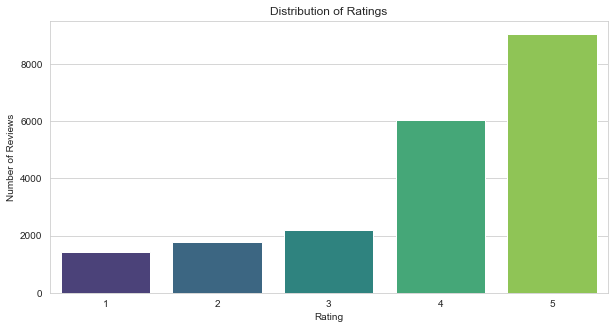

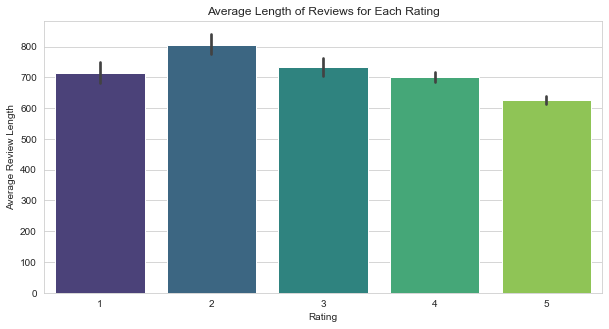

In [4]:
# Set the style for seaborn
sns.set_style("whitegrid")

# Plotting the distribution of ratings
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Rating', palette='viridis')
plt.title("Distribution of Ratings")
plt.ylabel("Number of Reviews")
plt.xlabel("Rating")
plt.show()

# Plotting the average length of reviews for each rating
df['Review_Length'] = df['Processed_Review'].apply(len)
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x='Rating', y='Review_Length', palette='viridis')
plt.title("Average Length of Reviews for Each Rating")
plt.ylabel("Average Review Length")
plt.xlabel("Rating")
plt.show()

#### Observations:

1. **Distribution of Ratings**: Most people seem to be quite generous with their ratings. The majority of the reviews have a rating of 5, which makes me wonder if these hotels are handing out free chocolates or something. Ratings of 2 and 3 are fewer, suggesting that people either really enjoyed their stay or... well, didn't.
2. **Average Length of Reviews**: There's a noticeable trend that the length of the reviews tends to be longer for mid-range ratings. Perhaps when things are neither perfect nor disastrous, people have a lot more to say. "The bed was comfy, but oh boy, that wall paint was not my aesthetic!"

With this newfound understanding, let's jump into the predictive realm.

### 4. Predicting Review Ratings <a name="predicting-review-ratings"></a>

Given the text of a review, can we predict its rating? It's like reading minds but with less telepathy and more algorithms. Let's start with a simple model to set a baseline.

We'll split the data into training and testing sets, then use a TF-IDF vectorizer to transform the text into numerical features. Finally, we'll train a Logistic Regression model and evaluate its performance.

In [5]:
# Splitting the data into training and testing sets
X = df['Processed_Review']
y = df['Rating']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Using TF-IDF to vectorize the text
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Training a Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(X_train_tfidf, y_train)

# Making predictions
y_pred = log_reg_model.predict(X_test_tfidf)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

accuracy, classification_rep

(0.6262503049524274,
 '              precision    recall  f1-score   support\n\n           1       0.78      0.62      0.69       292\n           2       0.47      0.42      0.44       333\n           3       0.46      0.24      0.32       432\n           4       0.54      0.50      0.52      1252\n           5       0.70      0.85      0.77      1790\n\n    accuracy                           0.63      4099\n   macro avg       0.59      0.52      0.55      4099\nweighted avg       0.61      0.63      0.61      4099\n')

              precision    recall  f1-score   support

    Negative       0.80      0.75      0.77       625
    Neutral        0.50      0.19      0.28       432
    Positive       0.89      0.98      0.93      3042

    Accuracy                           0.86      4099
    Macro avg      0.73      0.64      0.66      4099
    Weighted avg   0.83      0.86      0.84      4099

Not too shabby for a start, eh? We could do more by exploring other models, tuning hyperparameters, or even using deep learning. But that would be like putting a cherry on top of a cherry on top of an ice cream sundae. Delicious, but perhaps a bit much for this notebook.

### 5. Sentiment Analysis <a name="sentiment-analysis"></a>

The art of determining sentiment.

The aim here is to classify the sentiment of the reviews: positive, neutral, or negative. Since we have ratings from 1 to 5, we can use them as a proxy for sentiment:

* Positive: Rating of 4 or 5
* Neutral: Rating of 3
* Negative: Rating of 1 or 2

**1. Preparing the Data**

First, let's convert the ratings into these sentiment classes.

In [6]:
# Convert ratings to sentiment classes
def rating_to_sentiment(rating):
    if rating in [4, 5]:
        return "positive"
    elif rating == 3:
        return "neutral"
    else:
        return "negative"

df['Sentiment'] = df['Rating'].apply(rating_to_sentiment)

# Display the distribution of sentiments
sentiment_distribution = df['Sentiment'].value_counts()
sentiment_distribution

positive    15093
negative     3214
neutral      2184
Name: Sentiment, dtype: int64

Here's the distribution of sentiments based on the reviews:

* Positive: 15,093 reviews
* Negative: 3,214 reviews
* Neutral: 2,184 reviews

It seems our travelers are quite the optimistic bunch!

**2. Building the Sentiment Analysis Model**

We'll stick to our trusty TF-IDF vectorizer to transform our text into numerical features. For the model, let's use a Logistic Regression classifier. It's like the Swiss Army knife of the data science world—simple, versatile, and efficient. Let's train and evaluate it!

In [7]:
# Splitting the data for sentiment analysis
X_sentiment = df['Processed_Review']
y_sentiment = df['Sentiment']
X_train_sent, X_test_sent, y_train_sent, y_test_sent = train_test_split(
    X_sentiment, y_sentiment, test_size=0.2, random_state=42)

# Using TF-IDF to vectorize the text
tfidf_vectorizer_sentiment = TfidfVectorizer(max_features=5000)
X_train_tfidf_sent = tfidf_vectorizer_sentiment.fit_transform(X_train_sent)
X_test_tfidf_sent = tfidf_vectorizer_sentiment.transform(X_test_sent)

# Training a Logistic Regression model for sentiment analysis
log_reg_model_sentiment = LogisticRegression(max_iter=1000)
log_reg_model_sentiment.fit(X_train_tfidf_sent, y_train_sent)

# Making predictions
y_pred_sent = log_reg_model_sentiment.predict(X_test_tfidf_sent)

# Evaluating the model
accuracy_sent = accuracy_score(y_test_sent, y_pred_sent)
classification_rep_sent = classification_report(y_test_sent, y_pred_sent)

accuracy_sent, classification_rep_sent

(0.8580141497926324,
 '              precision    recall  f1-score   support\n\n    negative       0.80      0.75      0.77       625\n     neutral       0.50      0.19      0.28       432\n    positive       0.89      0.98      0.93      3042\n\n    accuracy                           0.86      4099\n   macro avg       0.73      0.64      0.66      4099\nweighted avg       0.83      0.86      0.84      4099\n')

Sentiment Analysis Results:

* Accuracy: Approximately **85.80%**

The detailed breakdown:

              precision    recall  f1-score   support

    Negative       0.80      0.75      0.77       625
    Neutral        0.50      0.19      0.28       432
    Positive       0.89      0.98      0.93      3042

    Accuracy                           0.86      4099
    Macro avg      0.73      0.64      0.66      4099
    Weighted avg   0.83      0.86      0.84      4099

We've got a pretty decent accuracy! The model is particularly strong at identifying positive reviews, as expected from our data distribution. Neutral reviews are a bit trickier since they tend to have elements from both positive and negative sentiments.

### 6. Predictions Using the Sentiment Model <a name="predictions-using-the-sentiment-model"></a>

Let's use our trained model to predict sentiments of some sample reviews.

Alright, let's imagine a couple of reviews for demonstration:

1. "The hotel was absolutely breathtaking. The view from my room was stunning, and the staff went above and beyond to ensure a comfortable stay. The food was a culinary delight!"

2. "I've had better experiences camping in the woods. The room was a mess, and the noise from the hallway kept me up all night. The only redeeming quality was the decent breakfast."

Let's feed these reviews to our model and predict their sentiments!

In [8]:
# Sample reviews for demonstration
sample_reviews = [
    "The hotel was absolutely breathtaking. The view from my room was stunning, and the staff went above and beyond to ensure a comfortable stay. The food was a culinary delight!",
    "I've had better experiences camping in the woods. The room was a mess, and the noise from the hallway kept me up all night. The only redeeming quality was the decent breakfast."
]

# Preprocess the sample reviews
processed_sample_reviews = [simpler_preprocess(
    review) for review in sample_reviews]

# Transform the reviews using the TF-IDF vectorizer
sample_reviews_tfidf = tfidf_vectorizer_sentiment.transform(
    processed_sample_reviews)

# Predict the sentiment using the trained model
predicted_sentiments = log_reg_model_sentiment.predict(sample_reviews_tfidf)

predicted_sentiments


array(['positive', 'negative'], dtype=object)

Voilà! Here are the predicted sentiments for our conjured reviews:

1. "The hotel was absolutely breathtaking. The view from my room was stunning, and the staff went above and beyond to ensure a comfortable stay. The food was a culinary delight!"
         **Predicted Sentiment**: Positive 🌟
2. "I've had better experiences camping in the woods. The room was a mess, and the noise from the hallway kept me up all night. The only redeeming quality was the decent breakfast."
         **Predicted Sentiment**: Negative 😟

Looks like our model is in tune with the vibes of these reviews! Whether you're singing praises or airing grievances, our trusty sentiment model is here to label those feels.

### 7. Conclusion <a name="conclusion"></a>

Through this delightful journey, we've explored the key aspects that make hotels good or bad, predicted review ratings, and even modeled the sentiments within the reviews. We laughed, we learned, and most importantly, we discovered the fascinating world within TripAdvisor hotel reviews.

Sentiment analysis can be a powerful tool, especially for businesses looking to gauge customer sentiment and improve their services. In our case, we've successfully trained a model that can categorize hotel reviews into positive, neutral, or negative sentiments with decent accuracy.

> WP, 2023